In [1]:
from jitcdde import jitcdde, y, t
from parameters_expanded import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from variables import *

In [2]:
# heat transfer functions
def dT_convective(a: list, b: y, hA_mcp: list):
    '''
    Energy from convective heat transfer
    a: from node(s) (state variable(s) y(i))
    b: to node (state variable y(i))
    hA_mcp: ratio of [convective heat transfer coefficient(s) * wetted area(s) (MW/C)]
            to [product of node mass (kg) and node specific heat capcity (MJ)/(kg*k)]
    f: fractional adjustments
    '''
    tot = 0.0
    for i in range(len(a)):
        tot += hA_mcp[i]*(a[i]-b)
    return tot

def dT_bulkFlow(W: float, m: float, a: y, b: y):
    '''
    Energy from bulk flow
    W: mass flow rate (kg/s)
    m: node mass (kg)
    a: Q from node (state variable y(i))
    b: Q to node (state variable y(i))
    '''
    return (a-b)*W/m

def dT_internal(k: float, P: float, mcp: float, n: y):
    '''
    Energy from fission
    k: fraction of power generation in node 
    P: nominal power (MW)
    mcp: product of node mass (kg) and node specific heat capacity (MJ/(kg*K))
    n: fractional neutron density 
    '''
    return k*P*n/mcp


Define system

In [3]:
# CORE
# fuel nodes
dc_f1 = dT_bulkFlow(W_f, m_f_c/2, (hx_fh1_f2(t-tau_hx_c_f)+hx_fh2_f2(t-tau_hx_c_f))/2,c_f1()) + dT_internal(k_f1, P, mcp_f_c, n()) + dT_convective([c_t1()],c_f1(),[hA_ft_c/mcp_f_c])  
dc_f2 = dT_bulkFlow(W_f, m_f_c/2, c_f1(), c_f2()) +                                             dT_internal(k_f1, P, mcp_f_c, n()) + dT_convective([c_t1()],c_f2(),[hA_ft_c/mcp_f_c])  

# tubes
dc_t1= dT_convective([c_f1(),c_f2(),c_c1(),c_c2()],c_t1(),[hA_ft_c/mcp_t_c,hA_ft_c/mcp_t_c,hA_tc_c/mcp_t_c,hA_tc_c/mcp_t_c])

# coolant 
dc_c1 = dT_bulkFlow(W_c,m_c_c/2,(hx_ch1_c2(t-tau_hx_c_c)+hx_ch2_c2(t-tau_hx_c_c))/2,c_c1()) + dT_convective([c_t1(),c_m()],c_c1(),[hA_tc_c/mcp_c_c,hA_mc_c/mcp_c_c])
dc_c2 = dT_bulkFlow(W_c,m_c_c/2,c_c1(),c_c2()) +                                              dT_convective([c_t1(),c_m()],c_c2(),[hA_tc_c/mcp_c_c,hA_mc_c/mcp_c_c])

# moderator 
dc_m =  dT_internal(k_m,P,mcp_m_c,n()) + dT_convective([c_c1(),c_c2()],c_m(),[hA_mc_c/mcp_m_c,hA_mc_c/mcp_m_c])


In [5]:
# FUEL-HELIUM HX1
# fuel nodes
T_hfh_f1 = W_f/(m_f_hx)*(c_f2(t-tau_c_hx_f)-hx_fh1_f1()) + F*(hA_ft_hx*(hx_fh1_t1()-hx_fh1_f1())/mcp_f_hx)                               # T_cf1: hx_fh1_f1()
T_hfh_f2 = W_f/(m_f_hx)*(hx_fh1_f1()-hx_fh1_f2()) + F*(hA_ft_hx*(hx_fh1_t1()-hx_fh1_f2())/mcp_f_hx)                                            # T_cf2: hx_fh1_f2()

# tubes
T_hfh_t1=F*((hA_ft_hx/mcp_t_hx)*((hx_fh1_f1()-hx_fh1_t1())+(hx_fh1_f2()-hx_fh1_t1()))+(hA_ht_hx/mcp_t_hx)*((hx_fh1_h1()-hx_fh1_t1())+(hx_fh1_h2()-hx_fh1_t1())))            # T_ht1: hx_fh1_t1()

# helium
T_hfh_h1 = W_h_fh/(m_h_hxfh)*(hx_hwf2_h2(t-tau_h)-hx_fh1_h1()) + F*(hA_ht_hx*(hx_fh1_t1()-hx_fh1_h1())/mcp_h_hxfh)                          # T_cc1: hx_fh1_h1() 
T_hfh_h2 = W_h_fh/(m_h_hxfh)*(hx_fh1_h1()-hx_fh1_h2()) + F*(hA_ht_hx*(hx_fh1_t1()-hx_fh1_h2())/mcp_h_hxfh)                                 # T_cc1: hx_fh1_h2() 

# FUEL-HELIUM HX2
# fuel nodes
T_hfh2_f1 = W_f/(m_f_hx)*(c_f2(t-tau_c_hx_f)-hx_fh2_f1()) + F*(hA_ft_hx*(hx_fh2_t1()-hx_fh2_f1())/mcp_f_hx)                           # T_cf1: hx_fh2_f1()
T_hfh2_f2 = W_f/(m_f_hx)*(hx_fh2_f1()-hx_fh2_f2()) + F*(hA_ft_hx*(hx_fh2_t1()-hx_fh2_f2())/mcp_f_hx)                                       # T_cf2: hx_fh2_f2()

# tubes
T_hfh2_t1=F*((hA_ft_hx/mcp_t_hx)*((hx_fh2_f1()-hx_fh2_t1())+(hx_fh2_f2()-hx_fh2_t1()))+(hA_ht_hx/mcp_t_hx)*((hx_fh2_h1()-hx_fh2_t1())+(hx_fh2_h2()-hx_fh2_t1())))    # T_ht1: hx_fh2_t1()

# helium
T_hfh2_h1 = W_h_fh/(m_h_hxfh)*(hx_hwf1_h2()-hx_fh2_h1()) + F*(hA_ht_hx*(hx_fh2_t1()-hx_fh2_h1())/mcp_h_hxfh)                        # T_cc1: hx_fh2_h1() 
T_hfh2_h2 = W_h_fh/(m_h_hxfh)*(hx_fh2_h1()-hx_fh2_h2()) + F*(hA_ht_hx*(hx_fh2_t1()-hx_fh2_h2())/mcp_h_hxfh)                                 # T_cc1: hx_fh2_h2() 


In [6]:


# COOLANT-HELIUM HX1
# fuel nodes
T_hch_c1 = W_c/(m_c_hx)*(c_c2(t-tau_c_hx_f)-hx_ch1_c1()) + F*(hA_ct_hx*(hx_ch1_t1()-hx_ch1_c1())/mcp_c_hxch)                        # T_cf1: hx_ch1_c1()
T_hch_c2 = W_c/(m_c_hx)*(hx_ch1_c1()-hx_ch1_c2()) + F*(hA_ct_hx*(hx_ch1_t1()-hx_ch1_c2())/mcp_c_hxch)                                    # T_cf2: hx_ch1_c2()

# tubes
T_hch_t1 = F*((hA_ct_hx/mcp_t_hxch)*((hx_ch1_c1()-hx_ch1_t1())+(hx_ch1_c2()-hx_ch1_t1()))+(hA_th_hxch/mcp_t_hxch)*((hx_ch1_h1()-hx_ch1_t1())+(hx_ch1_h2()-hx_ch1_t1())))   # T_ht1: hx_ch1_t1()

# helium
T_hch_h1 = W_h_ch/(m_h_hxch/2)*(hx_hwc1_h2(t-tau_h)-hx_ch1_h1()) + F*(hA_th_hxch*(hx_ch1_t1()-hx_ch1_h1())/mcp_h_hxch)                   # T_cc1: hx_ch1_h1() 
T_hch_h2 = W_h_ch/(m_h_hxch/2)*(hx_ch1_h1()-hx_ch1_h2()) + F*(hA_th_hxch*(hx_ch1_t1()-hx_ch1_h2())/mcp_h_hxch)                           # T_cc1: hx_ch1_h2() 


# COOLANT-HELIUM HX2
# fuel nodes
T_hch2_c1 = W_c/(m_c_hx)*(c_c2(t-tau_c_hx_f)-hx_ch2_c1()) + (hA_ct_hx*(hx_ch2_t1()-hx_ch2_c1())/mcp_c_hxch)                        # T_cf1: hx_ch2_c1()
T_hch2_c2 = W_c/(m_c_hx)*(hx_ch2_c1()-hx_ch2_c2()) + (hA_ct_hx*(hx_ch2_t1()-hx_ch2_c2())/mcp_c_hxch)                                    # T_cf2: hx_ch2_c2()

# tubes
T_hch2_t1 = F*((hA_ct_hx/mcp_t_hxch)*((hx_ch2_c1()-hx_ch2_t1())+(hx_ch2_c2()-hx_ch2_t1()))+(hA_th_hxch/mcp_t_hxch)*((hx_ch2_h1()-hx_ch2_t1())+(hx_ch2_h2()-hx_ch2_t1())))   # T_ht1: hx_ch2_t1()

# helium
T_hch2_h1 = W_h_ch/(m_h_hxch/2)*(hx_hwc2_h2(t-tau_h)-hx_ch2_h1()) + F*(hA_th_hxch*(hx_ch2_t1()-hx_ch2_h1())/mcp_h_hxch)                   # T_cc1: hx_ch2_h1() 
T_hch2_h2 = W_h_ch/(m_h_hxch/2)*(hx_ch2_h1()-hx_ch2_h2()) + F*(hA_th_hxch*(hx_ch2_t1()-hx_ch2_h2())/mcp_h_hxch)                           # T_cc1: hx_ch2_h2() 



In [7]:

# HELIUM-WATER HX1 (FUEL LOOP)
# helium
T_hhwf_h1 = W_h_fh/(m_h_hxhw/2)*(hx_fh1_h2()-hx_hwf1_h1()) + F*(hA_ht_hxhw*(hx_hwf1_t1()-hx_hwf1_h1())/mcp_h_hxhw)                  # T_cf1: hx_hwf1_h1()
T_hhwf_h2 = W_h_fh/(m_h_hxhw/2)*(hx_hwf1_h1()-hx_hwf1_h2()) + F*(hA_ht_hxhw*(hx_hwf1_t1()-hx_hwf1_h2())/mcp_h_hxhw)                          # T_cf2: hx_hwf1_h2()

# tubes
T_hhwf_t1 = F*((hA_ht_hxhw/mcp_t_hxhw)*((hx_hwf1_h1()-hx_hwf1_t1())+(hx_hwf1_h2()-hx_hwf1_t1()))+(hA_tw_hxhw/mcp_t_hxhw)*((hx_hwf1_w1()-hx_hwf1_t1())+(hx_hwf1_w2()-hx_hwf1_t1()))) # T_ht1: hx_hwf1_t1()

# water
T_hhwf_w1 = W_hhwf_w/(m_w/2)*(T0_hhwf_w1-hx_hwf1_w1()) + F*(hA_tw_hxhw*(hx_hwf1_t1()-hx_hwf1_w1())/mcp_w)                                       # T_cc1: hx_hwf1_w1() 
T_hhwf_w2 = W_hhwf_w/(m_w/2)*(hx_hwf1_w1()-hx_hwf1_w2()) + F*(hA_tw_hxhw*(hx_hwf1_t1()-hx_hwf1_w2())/mcp_w)                                            # T_cc1: hx_hwf1_w2() 


# HELIUM-WATER HX2 (FUEL LOOP)
# helium
T_hhwf2_h1 = W_h_fh/(m_h_hxhw/2)*(hx_fh2_h2()-hx_hwf2_h1()) + F*(hA_ht_hxhw*(hx_hwf2_t1()-hx_hwf2_h1())/mcp_h_hxhw)                       # T_cf1: hx_hwf2_h1()
T_hhwf2_h2 = W_h_fh/(m_h_hxhw/2)*(hx_hwf2_h1()-hx_hwf2_h2()) + F*(hA_ht_hxhw*(hx_hwf2_t1()-hx_hwf2_h2())/mcp_h_hxhw)                                   # T_cf2: hx_hwf2_h2()

# tubes
T_hhwf2_t1 = F*((hA_ht_hxhw/mcp_t_hxhw)*((hx_hwf2_h1()-hx_hwf2_t1())+(hx_hwf2_h2()-hx_hwf2_t1()))+(hA_tw_hxhw/mcp_t_hxhw)*((hx_hwf2_w1()-hx_hwf2_t1())+(hx_hwf2_w2()-hx_hwf2_t1()))) # T_ht1: hx_hwf2_t1()

# water
T_hhwf2_w1 = W_hhwf_w/(m_w/2)*(T0_hhwf_w1-hx_hwf2_w1()) + F*(hA_tw_hxhw*(hx_hwf2_t1()-hx_hwf2_w1())/mcp_w)                                       # T_cc1: hx_hwf2_w1() 
T_hhwf2_w2 = W_hhwf_w/(m_w/2)*(hx_hwf2_w1()-hx_hwf2_w2()) + F*(hA_tw_hxhw*(hx_hwf2_t1()-hx_hwf2_w2())/mcp_w)                                            # T_cc1: hx_hwf2_w2() 



In [8]:
# HELIUM-WATER HX1 (COOLANT LOOP)
# fuel nodes
T_hhwc_h1 = W_h_ch/(m_h_hxhwc/2)*(hx_ch1_h2()-hx_hwc1_h1()) + F*(hA_ht_hxhwc*(hx_hwc1_t1()-hx_hwc1_h1())/mcp_h_hxhwc)       # T_cf1: hx_hwc1_h1()
T_hhwc_h2 = W_h_ch/(m_h_hxhwc/2)*(hx_hwc1_h1()-hx_hwc1_h2()) + F*(hA_ht_hxhwc*(hx_hwc1_t1()-hx_hwc1_h2())/mcp_h_hxhwc)                                 # T_cf2: hx_hwc1_h2()

# tubes
T_hhwc_t1 = F*((hA_ht_hxhwc/mcp_t_hxhwc)*((hx_hwc1_h1()-hx_hwc1_t1())+(hx_hwc1_h2()-hx_hwc1_t1())) + (hA_tw_hxhwc/mcp_t_hxhwc)*((hx_hwc1_w1()-hx_hwc1_t1())+(hx_hwc1_w2()-hx_hwc1_t1()))) # T_ht1: hx_hwc1_t1()

# water
T_hhwc_w1 = W_hhwc_w/(m_w_hxhwc/2)*(T0_hhwf_w1-hx_hwc1_w1()) + F*(hA_tw_hxhwc*(hx_hwc1_t1()-hx_hwc1_w1())/mcp_w_hxhwc)                                       # T_cc1: hx_hwc1_w1() maybe don't need these nodes
T_hhwc_w2 = W_hhwc_w/(m_w_hxhwc/2)*(hx_hwc1_w1()-hx_hwc1_w2()) + F*(hA_tw_hxhwc*(hx_hwc1_t1()-hx_hwc1_w2())/mcp_w_hxhwc)                                            # T_cc1: hx_hwc1_w2() 

# HELIUM-WATER HX2 (COOLANT LOOP)
# fuel nodes
T_hhwc2_h1 = W_h_ch/(m_h_hxhwc/2)*(hx_ch2_h2()-hx_hwc2_h1()) + F*(hA_ht_hxhwc*(hx_hwc2_t1()-hx_hwc2_h1())/mcp_h_hxhwc)       # T_cf1: hx_hwc2_h1()
T_hhwc2_h2 = W_h_ch/(m_h_hxhwc/2)*(hx_hwc2_h1()-hx_hwc2_h2()) + F*(hA_ht_hxhwc*(hx_hwc2_t1()-hx_hwc2_h2())/mcp_h_hxhwc)                                 # T_cf2: hx_hwc2_h2()

# tubes
T_hhwc2_t1 = F*(hA_ht_hxhwc/mcp_t_hxhwc)*((hx_hwc2_h1()-hx_hwc2_t1())+(hx_hwc2_h2()-hx_hwc2_t1()))+(hA_tw_hxhwc/mcp_t_hxhwc)*((hx_hwc2_w1()-hx_hwc2_t1())+(hx_hwc2_w2()-hx_hwc2_t1())) # T_ht1: hx_hwc2_t1()

# water
T_hhwc2_w1 = W_hhwc_w/(m_w_hxhwc/2)*(T0_hhwf_w1-hx_hwc2_w1()) + F*(hA_tw_hxhwc*(hx_hwc2_t1()-hx_hwc2_w1())/mcp_w_hxhwc)                                       # T_cc1: hx_hwc2_w1() maybe don't need these nodes
T_hhwc2_w2 = W_hhwc_w/(m_w_hxhwc/2)*(hx_hwc2_w1()-hx_hwc2_w2()) + F*(hA_tw_hxhwc*(hx_hwc2_t1()-hx_hwc2_w2())/mcp_w_hxhwc)                                            # T_cc1: hx_hwc2_w2() 


In [9]:

dn = ((rho())-beta_t)*n()/Lam+lam[0]*C1()+lam[1]*C2()+lam[2]*C3()+lam[3]*C4()+lam[4]*C5()+lam[5]*C6()           # n (no source insertion): n()

# dC_i/dt (precursor concentrations)
dC1 = n()*beta[0]/Lam - lam[0]*C1() - C1()/tau_c + C1(t-tau_l)*np.exp(-lam[0]*tau_l)/tau_c                       # C1: y(27)
dC2 = n()*beta[1]/Lam - lam[1]*C2() - C2()/tau_c + C2(t-tau_l)*np.exp(-lam[1]*tau_l)/tau_c                       # C2: y(28)
dC3 = n()*beta[2]/Lam - lam[2]*C3() - C3()/tau_c + C3(t-tau_l)*np.exp(-lam[2]*tau_l)/tau_c                       # C3: y(29)
dC4 = n()*beta[3]/Lam - lam[3]*C4() - C4()/tau_c + C4(t-tau_l)*np.exp(-lam[3]*tau_l)/tau_c                       # C4: y(30)
dC5 = n()*beta[4]/Lam - lam[4]*C5() - C5()/tau_c + C5(t-tau_l)*np.exp(-lam[4]*tau_l)/tau_c                       # C5: y(31)
dC6 = n()*beta[5]/Lam - lam[5]*C6() - C6()/tau_c + C6(t-tau_l)*np.exp(-lam[5]*tau_l)/tau_c                       # C6: y(32)

# reactivity 
drho = (a_f/2)*(dc_f1 + dc_f2)+(a_b)*(dc_m)+(a_c/2)*(dc_c1+dc_c2)           # rho: y(33)

Initial values & solve

In [10]:
# instantiate jitcdde object
DDE = jitcdde([dc_f1,dc_f2,dc_t1,dc_c1,dc_c2,dc_m,
               T_hfh_f1,T_hfh_f2,T_hfh_t1,T_hfh_h1,T_hfh_h2,
               T_hfh2_f1,T_hfh2_f2,T_hfh2_t1,T_hfh2_h1,T_hfh2_h2,
               T_hch_c1,T_hch_c2,T_hch_t1,T_hch_h1,T_hch_h2,
               T_hch2_c1,T_hch2_c2,T_hch2_t1,T_hch2_h1,T_hch2_h2,
               T_hhwf_h1,T_hhwf_h2,T_hhwf_t1,T_hhwf_w1,T_hhwf_w2,
               T_hhwf2_h1,T_hhwf2_h2,T_hhwf2_t1,T_hhwf2_w1,T_hhwf2_w2,
               T_hhwc_h1,T_hhwc_h2,T_hhwc_t1,T_hhwc_w1,T_hhwc_w2,
               T_hhwc2_h1,T_hhwc2_h2,T_hhwc2_t1,T_hhwc2_w1,T_hhwc2_w2,
               dn,dC1,dC2,dC3,dC4,dC5,dC6,drho,
               ])

# set initial conditions
DDE.constant_past([T0_c_f1,T0_c_f2,T0_c_t1,T0_c_c1,T0_c_c2,T0_c_m+50,
                   T0_hfh_f1,T0_hfh_f2,T0_hfh_t1,T0_hfh_h1,T0_hfh_h2,
                   T0_hfh_f1,T0_hfh_f2,T0_hfh_t1,T0_hfh_h1,T0_hfh_h2,
                   T0_hch_c1,T0_hch_c2,T0_hch_t1,T0_hch_h1,T0_hch_h2,
                   T0_hch_c1,T0_hch_c2,T0_hch_t1,T0_hch_h1,T0_hch_h2,
                   T0_hhwf_h1,T0_hhwf_h2,T0_hhwf_t1,T0_hhwf_w1,T0_hhwf_w2,
                   T0_hhwf_h1,T0_hhwf_h2,T0_hhwf_t1,T0_hhwf_w1,T0_hhwf_w2,
                   T0_hhwc_h1,T0_hhwc_h2,T0_hhwc_t1,T0_hhwc_w1,T0_hhwc_w2,
                   T0_hhwc_h1,T0_hhwc_h2,T0_hhwc_t1,T0_hhwc_w1,T0_hhwc_w2,
                   n_frac0,C0[0],C0[1],C0[2],C0[3],C0[4],C0[5],0.0
                    ])

In [11]:


#DDE.set_integration_parameters(atol=1e-10, rtol=1e-05, first_step=1.0, min_step=1e-11, max_step=10.0, decrease_threshold=1.1, 
#                           increase_threshold=0.5, safety_factor=0.9, max_factor=5.0, min_factor=0.2, pws_factor=3, 
#                           pws_atol=0.0, pws_rtol=1e-05, pws_max_iterations=10, pws_base_increase_chance=0.1, pws_fuzzy_increase=False)
#
# DDE.step_on_discontinuities()

# jitcdde solver parameters 
t0 = 0.0
tf = 1000.00
T = np.arange(t0,tf,0.01)

sol_jit = []
for t_x in T:
    sol_jit.append(DDE.integrate(t_x))

Generating, compiling, and loading C code.
Using default integration parameters.


/mnt/envs/thesis_env/lib/python3.9/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/mnt/envs/thesis_env/lib/python3.9/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle in

In [12]:
nodes = ["c_f1", "c_f2", "c_t1", "c_c1", "c_c2", "c_m",
         "hx_fh1_f1", "hx_fh1_f2", "hx_fh1_t1", "hx_fh1_h1", "hx_fh1_h2",
         "hx_fh2_f1", "hx_fh2_f2", "hx_fh2_t1", "hx_fh2_h1", "hx_fh2_h2",
         "hx_ch1_c1", "hx_ch1_c2", "hx_ch1_t1", "hx_ch1_h1", "hx_ch1_h2",
         "hx_ch2_c1", "hx_ch2_c2", "hx_ch2_t1", "hx_ch2_h1", "hx_ch2_h2",
         "hx_hwf1_h1", "hx_hwf1_h2", "hx_hwf1_t1", "hx_hwf1_w1", "hx_hwf1_w2",
         "hx_hwf2_h1", "hx_hwf2_h2", "hx_hwf2_t1", "hx_hwf2_w1", "hx_hwf2_w2",
         "hx_hwc1_h1", "hx_hwc1_h2", "hx_hwc1_t1", "hx_hwc1_w1", "hx_hwc1_w2",
         "hx_hwc2_h1", "hx_hwc2_h2", "hx_hwc2_t1", "hx_hwc2_w1", "hx_hwc2_w2",
         "n", "C1", "C2", "C3", "C4", "C5", "C6", "rho",]


#for v in enumerate(DDE.get_state()[2][1]):
#    print(f"{nodes[v[0]]} val: {DDE.get_state()[2][1][v[0]]}, deriv: {DDE.get_state()[2][2][v[0]]}")

(0.0, 250.0)

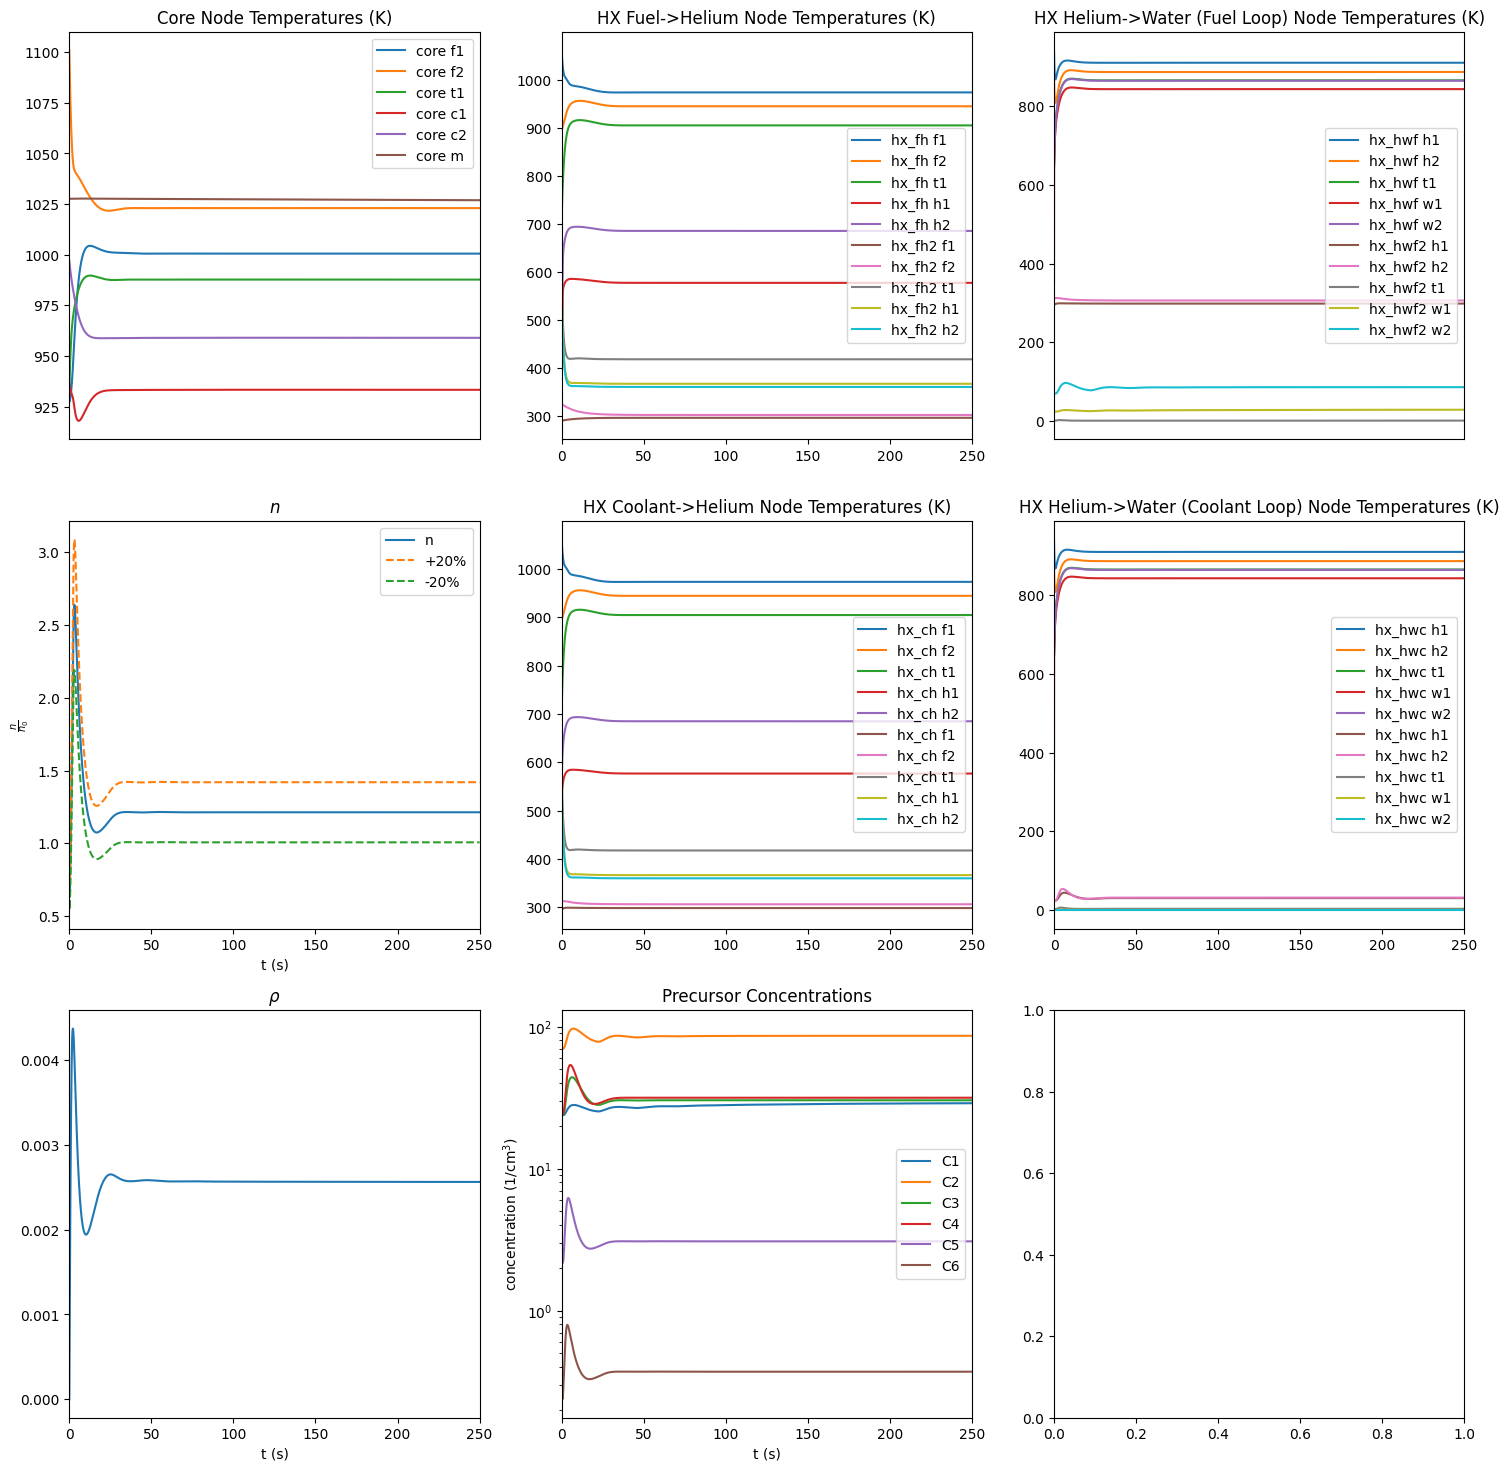

In [13]:
fig,axs = plt.subplots(3,3,figsize=(18,18))

t_0 = 0.0
t_f = 250

p_error = 0.17

axs[0,0].set_xlim([t_0,t_f])
axs[0,0].plot(T,[s[0] for s in sol_jit],label="core f1") 
axs[0,0].plot(T,[s[1] for s in sol_jit],label="core f2") 
axs[0,0].plot(T,[s[2] for s in sol_jit],label="core t1")  
axs[0,0].plot(T,[s[3] for s in sol_jit],label="core c1")
axs[0,0].plot(T,[s[4] for s in sol_jit],label="core c2")
axs[0,0].plot(T,[s[5] for s in sol_jit],label="core m")
axs[0,0].legend()
axs[0,0].set_title("Core Node Temperatures (K)")
axs[0,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


axs[0,1].set_xlim([t_0,t_f])
# axs[0,1].set_ylim([650,750])
axs[0,1].plot(T,[s[6] for s in sol_jit],label="hx_fh f1") 
axs[0,1].plot(T,[s[7] for s in sol_jit],label="hx_fh f2") 
axs[0,1].plot(T,[s[8] for s in sol_jit],label="hx_fh t1")  
axs[0,1].plot(T,[s[9] for s in sol_jit],label="hx_fh h1")
axs[0,1].plot(T,[s[10] for s in sol_jit],label="hx_fh h2")
axs[0,1].plot(T,[s[34] for s in sol_jit],label="hx_fh2 f1") 
axs[0,1].plot(T,[s[35] for s in sol_jit],label="hx_fh2 f2") 
axs[0,1].plot(T,[s[36] for s in sol_jit],label="hx_fh2 t1")  
axs[0,1].plot(T,[s[37] for s in sol_jit],label="hx_fh2 h1")
axs[0,1].plot(T,[s[38] for s in sol_jit],label="hx_fh2 h2")

axs[0,1].legend()
axs[0,1].set_title("HX Fuel->Helium Node Temperatures (K)")
#axs[0,1].tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off

axs[0,2].set_xlim([t_0,t_f])
axs[0,2].plot(T,[s[16] for s in sol_jit],label="hx_hwf h1") 
axs[0,2].plot(T,[s[17] for s in sol_jit],label="hx_hwf h2") 
axs[0,2].plot(T,[s[18] for s in sol_jit],label="hx_hwf t1")  
axs[0,2].plot(T,[s[19] for s in sol_jit],label="hx_hwf w1")
axs[0,2].plot(T,[s[20] for s in sol_jit],label="hx_hwf w2")
axs[0,2].plot(T,[s[44] for s in sol_jit],label="hx_hwf2 h1") 
axs[0,2].plot(T,[s[45] for s in sol_jit],label="hx_hwf2 h2") 
axs[0,2].plot(T,[s[46] for s in sol_jit],label="hx_hwf2 t1")  
axs[0,2].plot(T,[s[47] for s in sol_jit],label="hx_hwf2 w1")
axs[0,2].plot(T,[s[48] for s in sol_jit],label="hx_hwf2 w2")
axs[0,2].legend()
axs[0,2].set_title("HX Helium->Water (Fuel Loop) Node Temperatures (K)")
axs[0,2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axs[1,1].set_xlim([t_0,t_f])
axs[1,1].plot(T,[s[11] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[12] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[13] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[14] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[15] for s in sol_jit],label="hx_ch h2")
axs[1,1].plot(T,[s[39] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[40] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[41] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[42] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[43] for s in sol_jit],label="hx_ch h2")
axs[1,1].legend()
axs[1,1].legend()
axs[1,1].set_title("HX Coolant->Helium Node Temperatures (K)")

# fuel temps
axs[1,2].set_xlim([t_0,t_f])
axs[1,2].plot(T,[s[21] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[22] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[23] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[24] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[25] for s in sol_jit],label="hx_hwc w2")
axs[1,2].plot(T,[s[49] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[50] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[51] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[52] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[53] for s in sol_jit],label="hx_hwc w2")
axs[1,2].legend()
axs[1,2].set_title("HX Helium->Water (Coolant Loop) Node Temperatures (K)")

axs[1,0].plot(T,[s[46] for s in sol_jit],label="n") 
axs[1,0].plot(T,[(1+p_error)*s[46] for s in sol_jit],linestyle="--",label="+20%") 
axs[1,0].plot(T,[(1-p_error)*s[46] for s in sol_jit],linestyle="--",label="-20%") 
axs[1,0].set_xlabel("t (s)")
axs[1,0].set_title(r"$n$")
axs[1,0].set_ylabel(r"$\frac{n}{n_0}$")
axs[1,0].set_xlim([t_0,t_f])
axs[1,0].legend()

axs[2,0].plot(T,[s[53] for s in sol_jit],label="rho") 
axs[2,0].set_xlabel("t (s)")
axs[2,0].set_title(r"$\rho$")
axs[2,0].set_xlim([t_0,t_f])

axs[2,1].plot(T,[s[47] for s in sol_jit],label="C1") 
axs[2,1].plot(T,[s[48] for s in sol_jit],label="C2") 
axs[2,1].plot(T,[s[49] for s in sol_jit],label="C3")  
axs[2,1].plot(T,[s[50] for s in sol_jit],label="C4")
axs[2,1].plot(T,[s[51] for s in sol_jit],label="C5")
axs[2,1].plot(T,[s[52] for s in sol_jit],label="C6")
axs[2,1].legend()
axs[2,1].set_xlabel("t (s)")
axs[2,1].set_yscale("log")
axs[2,1].set_ylabel(r"concentration (1/cm$^3$)")
axs[2,1].legend(loc="right")
axs[2,1].set_title("Precursor Concentrations")
axs[2,1].set_xlim([t_0,t_f])


In [14]:
print((1-p_error)*sol_jit[-1][46])
print(sol_jit[-1][46])
print((1+p_error)*sol_jit[-1][46])
print(sol_jit[-1][53])

1.0083055110635513
1.2148259169440376
1.421346322824524
0.0025639367678885893


Text(0.5, 0, '$t$(s)')

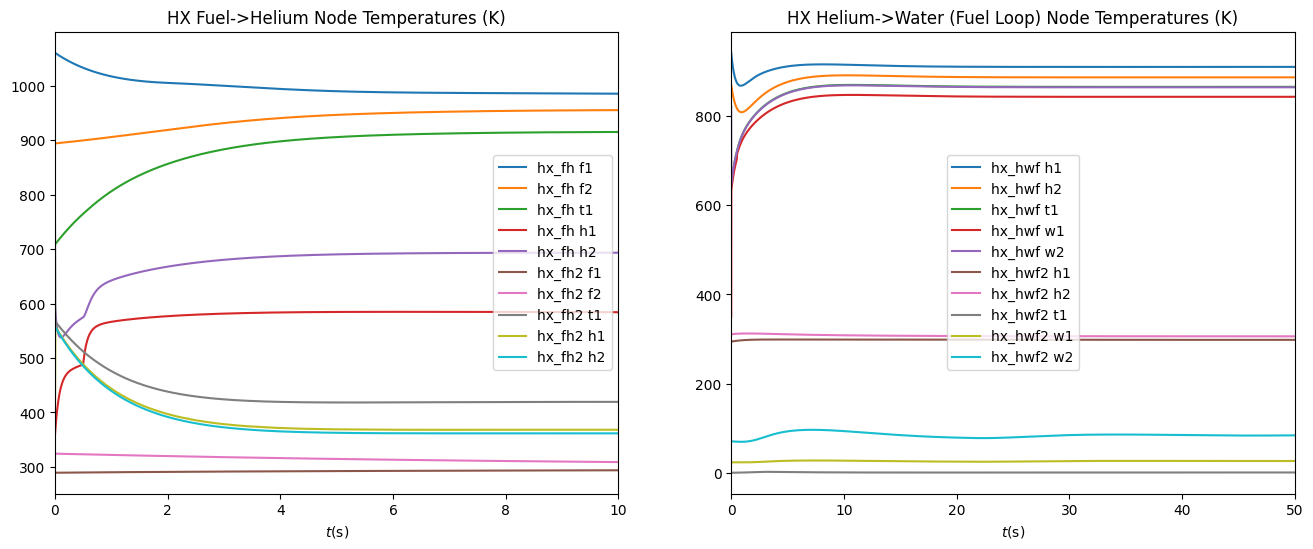

In [15]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

axs[0].set_xlim([t_0,10])
# axs[0,1].set_ylim([650,750])
axs[0].plot(T,[s[6] for s in sol_jit],label="hx_fh f1") 
axs[0].plot(T,[s[7] for s in sol_jit],label="hx_fh f2") 
axs[0].plot(T,[s[8] for s in sol_jit],label="hx_fh t1")  
axs[0].plot(T,[s[9] for s in sol_jit],label="hx_fh h1")
axs[0].plot(T,[s[10] for s in sol_jit],label="hx_fh h2")
axs[0].plot(T,[s[34] for s in sol_jit],label="hx_fh2 f1") 
axs[0].plot(T,[s[35] for s in sol_jit],label="hx_fh2 f2") 
axs[0].plot(T,[s[36] for s in sol_jit],label="hx_fh2 t1")  
axs[0].plot(T,[s[37] for s in sol_jit],label="hx_fh2 h1")
axs[0].plot(T,[s[38] for s in sol_jit],label="hx_fh2 h2")
axs[0].set_title("HX Fuel->Helium Node Temperatures (K)")
axs[0].legend(loc="right")
axs[0].set_xlabel(r"$t$(s)")

axs[1].set_xlim([t_0,50])
axs[1].plot(T,[s[16] for s in sol_jit],label="hx_hwf h1") 
axs[1].plot(T,[s[17] for s in sol_jit],label="hx_hwf h2") 
axs[1].plot(T,[s[18] for s in sol_jit],label="hx_hwf t1")  
axs[1].plot(T,[s[19] for s in sol_jit],label="hx_hwf w1")
axs[1].plot(T,[s[20] for s in sol_jit],label="hx_hwf w2")
axs[1].plot(T,[s[44] for s in sol_jit],label="hx_hwf2 h1") 
axs[1].plot(T,[s[45] for s in sol_jit],label="hx_hwf2 h2") 
axs[1].plot(T,[s[46] for s in sol_jit],label="hx_hwf2 t1")  
axs[1].plot(T,[s[47] for s in sol_jit],label="hx_hwf2 w1")
axs[1].plot(T,[s[48] for s in sol_jit],label="hx_hwf2 w2")
axs[1].set_title("HX Helium->Water (Fuel Loop) Node Temperatures (K)")
axs[1].legend()
axs[1].set_xlabel(r"$t$(s)")

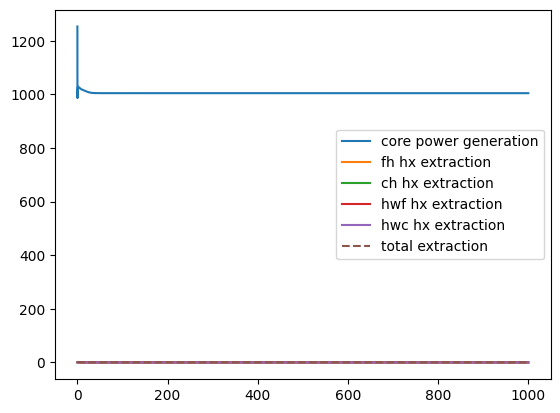

In [16]:
# power generation from fission 

# core power generation
pow_f1 = [k_f1*P*s[26] for s in sol_jit]
pow_f2 = [k_f2*P*s[26] for s in sol_jit]
tot_pow = np.add(pow_f1,pow_f2)

# heat extracted by fuel-helium hx
fh_ex = [(s[1]-s[0])*W_f*scp_f for s in sol_jit]

# heat extracted by coolant-helium hx
ch_ex = [(s[4]-s[3])*W_c*scp_c for s in sol_jit]

# helium-> water (fuel loop)
hwf_ex = [(s[10]-s[9])*W_h_fh*scp_h for s in sol_jit]

# helium-> water (coolant loop)
hwc_ex = [(s[15]-s[14])*W_h_ch*scp_h for s in sol_jit]

tot_ex = [fh_ex[i]+ch_ex[i]+hwf_ex[i]+hwc_ex[i] for i in range(len(sol_jit))]

plt.plot(T,tot_pow,label="core power generation")
plt.plot(T,fh_ex,label="fh hx extraction")
plt.plot(T,ch_ex,label="ch hx extraction")
plt.plot(T,hwf_ex,label="hwf hx extraction")
plt.plot(T,hwc_ex,label="hwc hx extraction")
plt.plot(T,tot_ex,label="total extraction",linestyle="--")
plt.legend()
